# Part 1

In [26]:
import pandas as pd
import numpy as np
import math
from collections import defaultdict

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime as dt
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, recall_score, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import RegressorMixin

In [27]:
# Read the datasets
patients, immunizations = pd.read_csv('patients_db_v2.csv'), pd.read_csv('immunization_db_v2.csv')

In [28]:
# Extract the vaccine information for each patient from immunization_db_v2.csv.
# If a vaccine dose is not successful, set that vaccine dose date to 1/1/2100.

data_dict = defaultdict(lambda: defaultdict(list))


for row in immunizations.itertuples(index=False):

    if row.vaccine == 'OPV':
        if row.successful:
            data_dict[row.pat_id]['OPV'].append(row.im_date)
        else:
            data_dict[row.pat_id]['OPV'].append('1/1/2100')
            
    if row.vaccine == 'DTP':
        if row.successful:
            data_dict[row.pat_id]['DTP'].append(row.im_date)
        else:
            data_dict[row.pat_id]['DTP'].append('1/1/2100')


In [29]:
# Extract the gender, district, and dob of a patient from patients_db_v2.csv
for row in patients.itertuples(index=False):    
    data_dict[row.pat_id]['DOB'] = row.dob
    data_dict[row.pat_id]['District'] = row.district
    data_dict[row.pat_id]['gender'] = row.gender

    
# Assume that missing vaccine dose information means that patient never received that dose.
# Fill in those missing vaccine dose dates with 1/1/2100.
for value in data_dict.values():
    while len(value['OPV']) < 4:
        value['OPV'].append('1/1/2100')
        
    while len(value['DTP']) < 3:
        value['DTP'].append('1/1/2100')

In [30]:
# Create a pandas datframe with all the patient information and vaccine information
structured_data_list = []
for key, value in data_dict.items():
    structured_data_list.append([key, value['DOB'], value['gender'], value['District']] + value['OPV'] + value['DTP'])

structured_data = pd.DataFrame(structured_data_list, columns = ['pat_id', 'dob', 'gender', 'district', 'opv1', 'opv2', 'opv3', 'opv4', 'dtp1', 'dtp2', 'dtp3'])

In [31]:
# Create the true intervention lables based on if the patiend received all 7 vaccines by 6 months (180 days) of age.

labels_list = []
for row in structured_data.itertuples(index=False):
    labels_list.append((dt.strptime(row.opv1, "%m/%d/%Y") - dt.strptime(row.dob, "%m/%d/%Y")).days > 180 or \
                       (dt.strptime(row.opv2, "%m/%d/%Y") - dt.strptime(row.dob, "%m/%d/%Y")).days > 180 or \
                       (dt.strptime(row.opv3, "%m/%d/%Y") - dt.strptime(row.dob, "%m/%d/%Y")).days > 180 or \
                       (dt.strptime(row.opv4, "%m/%d/%Y") - dt.strptime(row.dob, "%m/%d/%Y")).days > 180 or \
                       (dt.strptime(row.dtp1, "%m/%d/%Y") - dt.strptime(row.dob, "%m/%d/%Y")).days > 180 or \
                       (dt.strptime(row.dtp2, "%m/%d/%Y") - dt.strptime(row.dob, "%m/%d/%Y")).days > 180 or \
                       (dt.strptime(row.dtp2, "%m/%d/%Y") - dt.strptime(row.dob, "%m/%d/%Y")).days > 180)

structured_data['intervene'] = labels_list

In [32]:
structured_data.head()

,pat_id,dob,gender,district,opv1,opv2,opv3,opv4,dtp1,dtp2,dtp3,intervene
0,1,1/22/2019,f,Ghanzi,1/31/2019,4/3/2019,5/25/2019,7/6/2019,4/3/2019,5/25/2019,7/6/2019,False
1,2,11/12/2019,f,Chobe,11/12/2019,1/1/2100,1/1/2100,1/1/2100,1/1/2100,1/1/2100,1/1/2100,True
2,3,11/3/2019,m,Tutume,11/3/2019,12/17/2019,1/1/2100,1/1/2100,12/17/2019,1/1/2100,1/1/2100,True
3,4,4/17/2019,f,Lethlakane,6/1/2019,8/24/2019,10/14/2019,12/14/2019,7/14/2019,10/14/2019,12/14/2019,True
4,5,12/8/2018,m,Tuli,12/24/2018,2/10/2019,3/18/2019,4/27/2019,2/10/2019,3/18/2019,1/1/2100,False


In [33]:
# We can use vaccine information upto 4 (120 days) months of a patients' birth.
# Convert all the vaccine dose columns into flags indicating if they received that dose by 120 days of their birth.

structured_data.opv1 = (pd.to_datetime(structured_data.opv1) - pd.to_datetime(structured_data.dob)).dt.days <= 120
structured_data.opv2 = (pd.to_datetime(structured_data.opv2) - pd.to_datetime(structured_data.dob)).dt.days <= 120
structured_data.opv3 = (pd.to_datetime(structured_data.opv3) - pd.to_datetime(structured_data.dob)).dt.days <= 120
structured_data.opv4 = (pd.to_datetime(structured_data.opv4) - pd.to_datetime(structured_data.dob)).dt.days <= 120
structured_data.dtp1 = (pd.to_datetime(structured_data.dtp1) - pd.to_datetime(structured_data.dob)).dt.days <= 120
structured_data.dtp2 = (pd.to_datetime(structured_data.dtp2) - pd.to_datetime(structured_data.dob)).dt.days <= 120
structured_data.dtp3 = (pd.to_datetime(structured_data.dtp3) - pd.to_datetime(structured_data.dob)).dt.days <= 120

structured_data = structured_data.replace([True, False], [1, 0])

In [34]:
# Create separate columns for day, month, year to handle the date string feature.
structured_data['year'] = pd.to_datetime(structured_data['dob']).dt.year
structured_data['month'] = pd.to_datetime(structured_data['dob']).dt.month
structured_data['day'] = pd.to_datetime(structured_data['dob']).dt.day

# Drop the dob and pat_id column.
structured_data = structured_data.drop(['pat_id', 'dob'], axis = 1)

structured_data.head()

,gender,district,opv1,opv2,opv3,opv4,dtp1,dtp2,dtp3,intervene,year,month,day
0,f,Ghanzi,1,1,0,0,1,0,0,0,2019,1,22
1,f,Chobe,1,0,0,0,0,0,0,1,2019,11,12
2,m,Tutume,1,1,0,0,1,0,0,1,2019,11,3
3,f,Lethlakane,1,0,0,0,1,0,0,1,2019,4,17
4,m,Tuli,1,1,1,0,1,1,0,0,2018,12,8


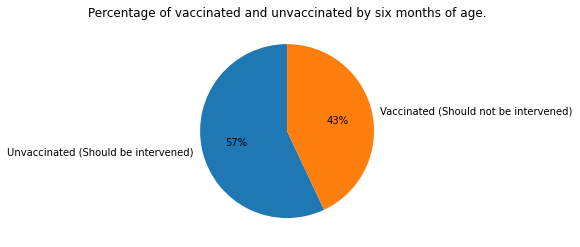

In [35]:
# Plot the proportion of fully vaccinated vs not fully vaccinated by six months of age.
# Not full vaccinted patients will be intervened by the health workers.

unvax_vax = round(((structured_data.intervene.value_counts() / structured_data.intervene.count())*100))

plt.pie(unvax_vax, labels=['Unvaccinated (Should be intervened)', 'Vaccinated (Should not be intervened)'], autopct='%1.0f%%', startangle=90)
plt.title('Percentage of vaccinated and unvaccinated by six months of age.');


In [36]:
# Check for any missing values in gender and district
print("There are {} missing districts.".format(structured_data.district.isna().sum()))
print("There are {} missing gender information.".format(structured_data.gender.isna().sum()))

There are 1634 missing districts.
There are 1002 missing gender information.


In [37]:
# Since the fraction of missing values is not significant, we'll create another category for missing values.
structured_data.gender = structured_data.gender.fillna("unknown")
structured_data.district = structured_data.district.fillna("unknown")

<AxesSubplot:xlabel='gender'>

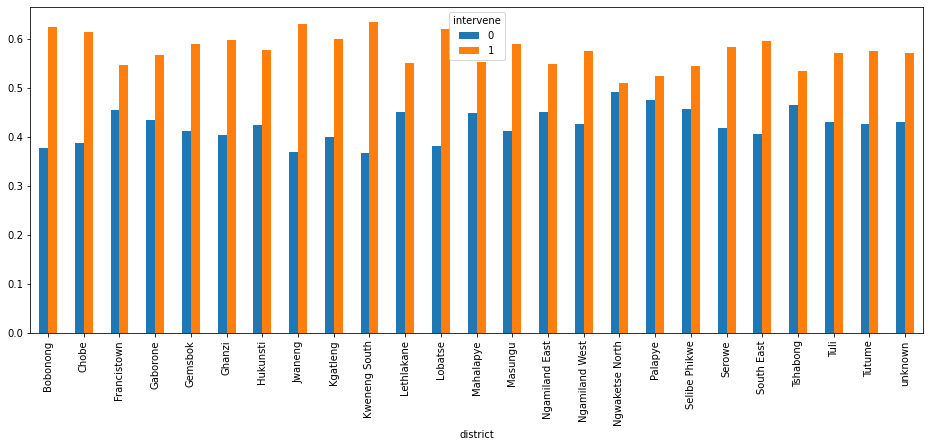

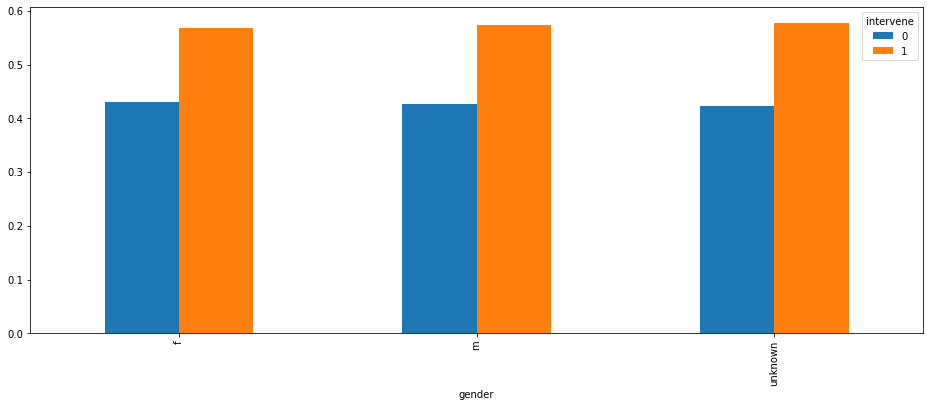

In [38]:
# Check the proportion of vaccination levels in different districts and genders.
structured_data.groupby('district')['intervene'].value_counts(normalize=True).unstack(level=1).plot.bar(figsize = (16, 6))
structured_data.groupby('gender')['intervene'].value_counts(normalize=True).unstack(level=1).plot.bar(figsize = (16, 6))

# From the graphs, there is no significant difference in vaccination levels in different districts and different genders.

In [39]:
# Do one hot encoding given that our dataset is of size 50000.
# Create one-hot encoding for categorical variables "gender" and "district". 
structured_data_encoded = pd.get_dummies(structured_data)

In [40]:
# Observe the data.
structured_data_encoded.describe()

,opv1,opv2,opv3,opv4,dtp1,dtp2,dtp3,intervene,year,month,...,district_Ngamiland West,district_Ngwaketse North,district_Palapye,district_Selibe Phikwe,district_Serowe,district_South East,district_Tshabong,district_Tuli,district_Tutume,district_unknown
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.972600,0.831780,0.513080,0.186440,0.861060,0.552620,0.209580,0.57120,2018.501500,6.523040,...,0.034180,0.005820,0.002860,0.013640,0.030360,0.033020,0.006100,0.085220,0.080840,0.032680
std,0.163248,0.374065,0.499834,0.389465,0.345887,0.497228,0.407013,0.49491,0.500003,3.448169,...,0.181693,0.076067,0.053403,0.115992,0.171578,0.178691,0.077865,0.279212,0.272592,0.177799
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2018.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,2018.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.00000,2019.000000,7.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.00000,2019.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,2019.000000,12.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:title={'center':'Fraction of patients who received the vaccine doses.'}>

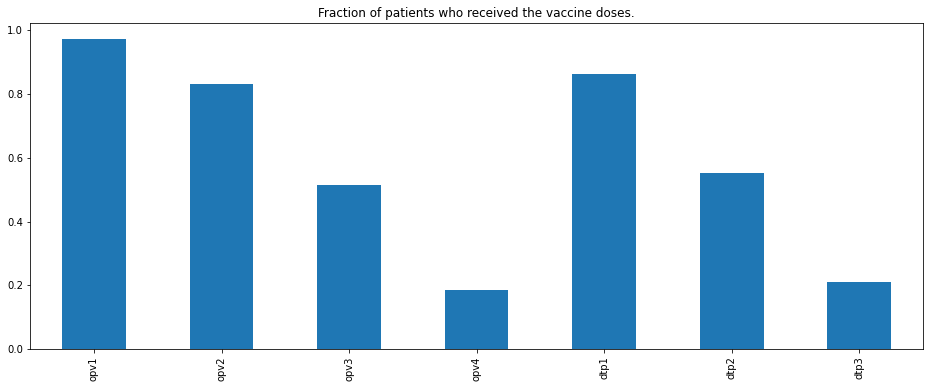

In [41]:
# Observe the fraction of patients who received the doses by four months of age
vaccines = ['opv1', 'opv2', 'opv3', 'opv4', 'dtp1', 'dtp2', 'dtp3']
structured_data[vaccines].mean().plot.bar(figsize = (16, 6), title = 'Fraction of patients who received the vaccine doses.')

In [42]:
# separate the features and labels
x, y = structured_data_encoded.drop('intervene', axis=1), structured_data_encoded['intervene']

# train test split
x_train, x_test, y_train, y_test= train_test_split(x,y, test_size = 0.3, random_state=1)

In [43]:
# We define a simple non-ML baseline that if the total number of vaccine doses recived by the patient
# before four months of age is less than 4, they should be intervened.
from sklearn.base import BaseEstimator, ClassifierMixin

class Baseline(ClassifierMixin, BaseEstimator):

    def __init__(self):
        pass

    def fit(self, xtrain = None, y_train = None):
        return self

    def predict(self, data):
        return data.opv1 + data.opv2 + data.opv3 + data.opv4 + data.dtp1 + data.dtp2 + data.dtp3 < 4


In [44]:
# compare various classification models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# prepare models
models = []

models.append(('DT', DecisionTreeClassifier(random_state=1)))
models.append(('LR', LogisticRegression(random_state=1)))
models.append(('RF', RandomForestClassifier(random_state=1)))
models.append(('XGB', XGBClassifier(random_state=1)))
models.append(('KNN', KNeighborsClassifier()))


# Evaluate each model in turn with cross validation.
results_recall, results_roc_auc, results_precision = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

names = []

scoring = ['recall', 'precision', 'roc_auc']

for name, model in models:

        # split dataset into 10 folds. Use one fold for validation and remaining 9 folds for training.
        skf= StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
        cv_results = cross_validate(model, x_train, y_train, cv=skf, scoring=scoring)
        results_precision[name] = cv_results['test_precision']
        results_recall[name] = cv_results['test_recall']
        results_roc_auc[name] = cv_results['test_roc_auc']

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

[01:43:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:43:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


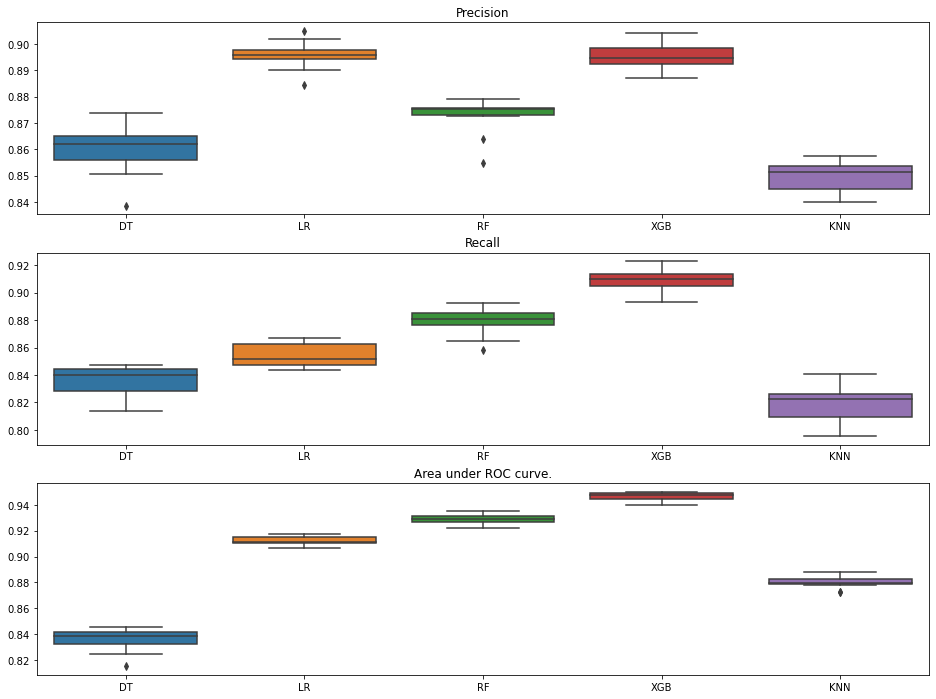

In [45]:
# Plot and compare the precision, recall, and area under the curve.

fig, axes = plt.subplots(3, 1, figsize = (16, 12))

sns.boxplot(ax = axes[0], data = results_precision)
axes[0].set_title('Precision')

sns.boxplot(ax = axes[1], data = results_recall)
axes[1].set_title('Recall')

sns.boxplot(ax = axes[2], data = results_roc_auc)
axes[2].set_title('Area under ROC curve.')
plt.show()

In [46]:
model_xg, baseline = XGBClassifier(random_state=1), Baseline()
model_xg.fit(x_train, y_train)
baseline.fit(x_train, y_train)

# Compare XGBoost and Baseline classification reports.
print(classification_report(y_test, model_xg.predict(x_test)))
print(classification_report(y_test, baseline.predict(x_test)))

C:\Anaconda\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:44:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      6502
           1       0.89      0.92      0.90      8498

    accuracy                           0.89     15000
   macro avg       0.89      0.88      0.89     15000
weighted avg       0.89      0.89      0.89     15000

              precision    recall  f1-score   support

           0       0.65      0.89      0.75      6502
           1       0.88      0.63      0.73      8498

    accuracy                           0.74     15000
   macro avg       0.76      0.76      0.74     15000
weighted avg       0.78      0.74      0.74     15000



# Part 2